-----

## The objective of the decision tree is to predict, for a mainshock of magnitude greater than 5, whether there will be at least one aftershock of magnitude greater than 5 within the next month.

Motivation : 5 is a big magnitude for earthquakes and can cause a lot of damage. When an earthquake with a magnitude greater than 5 occurs, we would like to know whether there will be large foreshocks (for example, in the next month). To do this, we have to limit our study to the mainshocks of magnitude greater than 5. If a mainshock has a magnitude of 4, there is no chance of a large aftershock.

Hypothesis : 

- We work only on the regions with a lot of seismicity (ie containing 10 or more temporal clusters,to get more accurate data). This means that we cant make any prediction if the shock happens in any other region

- We work only with mainshocks that have a magnitude stronger than 5, and that have at least one foreshock and one aftershock (We don't want to work on isolated shocks)

- In real life, we can't know whether a shock is the mainshock or not until we see the magnitude decrease. For this study, we assume that we know the mainshock and its foreshocks.
                         

In [427]:
##imports
import os
import sys
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from sklearn.metrics import accuracy_score, classification_report
# to make this notebook's output stable across runs
np.random.seed(42)

#import decision Tree module
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

#for splitting data
from sklearn.model_selection import train_test_split
#other
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler


#Personal functions
sys.path.append('../scripts')
current_directory = os.getcwd()
clusters_folder_path = os.path.join(current_directory,'../ressources/clusters')
clusters_filename = 'clusters_dataset.csv'
cluster_file_path = os.path.join(clusters_folder_path,clusters_filename)


---

## Data loading and adding rows to the init file

In [428]:
#data loading 
clusters_df = pd.read_csv(cluster_file_path)
clusters_df.head()

#we add a column to know if the earthquake was a mainshock ,a foreshock or an aftershock
#0 if mainshock ; 1 if aftershock, -1 is foreshock
clusters_df['mainshock'] = pd.Series(dtype=float)
for index, row in clusters_df.iterrows():
    if row['delta_days'] == 0. :
        clusters_df.at[index,'mainshock'] = 0
    elif row['delta_days'] > 0. : 
        clusters_df.at[index,'mainshock'] = 1
    elif row['delta_days'] < 0. :
        clusters_df.at[index,'mainshock'] = -1
clusters_df['date'] = pd.to_datetime(clusters_df['time'])
#We need to know the year and the month to make statistics later on years and months
clusters_df['year'] = clusters_df['date'].dt.to_period('Y')
clusters_df['month'] = clusters_df['date'].dt.to_period('M')
clusters_df['week'] = clusters_df['date'].dt.to_period('W')



C:\Users\33626\AppData\Local\Temp\ipykernel_4836\3810979275.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  clusters_df['year'] = clusters_df['date'].dt.to_period('Y')
C:\Users\33626\AppData\Local\Temp\ipykernel_4836\3810979275.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  clusters_df['month'] = clusters_df['date'].dt.to_period('M')
C:\Users\33626\AppData\Local\Temp\ipykernel_4836\3810979275.py:19: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  clusters_df['week'] = clusters_df['date'].dt.to_period('W')


---
## We want to get specific data for each geographical region

In [429]:
def compute_AS_dist(relevant_shocks):
    """
    This function calculates the standard distances of the input data."""
    data = np.vstack((relevant_shocks.longitude,relevant_shocks.latitude)).T
    if len(data)>1:
        cov_matrix = np.cov(data, rowvar=False)
        eigenvalues, _ = np.linalg.eigh(cov_matrix)
        if np.any(eigenvalues <= 0):
            return None
        std_distance = np.sqrt(np.sum(eigenvalues))
        return std_distance
    else:
        return None

In [448]:
## In this cell, we group the data by geographical clusers and we calculate stats on these specific regions

#We group the data by geographical clusters.
region_data = clusters_df.groupby(['MC_lab','SC_lab'])

#we want to know if the shock is small, moderate or large
mag_bins = [0, 5, 6, 10]
mag_labels = ['small','moderate', 'large']
result_columns = [f'shocks_{category}' for category in mag_labels]

#these lists are made to stock useful information on the clusters. We will then add  them in our data frame
yearly_variations_list = []
monthly_variations_list = []
weekly_variations_list = []
yearly_mean_list = []
monthly_mean_list = []
weekly_mean_list = []
proba_region_aftershock_mag_sup_M_in_next_month_lst = []
result_data= []
MC_lab_list = []
SC_lab_list = []
labels_to_drop = []
std_distance_lst = []

for cluster_label, cluster_data in region_data:
    # we decide to take the regions with 10 or more temporal clusters. If there are to few clusters,the statistics won't be relevant.
    if len(cluster_data)>10 :
        #We count the numbers of shocks each year and month (for each zone), and we calculate the mean and the std
        #The std is useful to get information on the variation
        shocks_per_year = np.nan_to_num(cluster_data['year'].value_counts(), nan=0)
        shocks_per_month_per_year = np.nan_to_num(cluster_data.groupby(['year','month']).size(),nan = 0)
        shocks_per_week_per_month_per_year = np.nan_to_num(cluster_data.groupby(['year','month','week']).size(),nan = 0)
        
        #we add a lot of stats on the zones
        std_distance = compute_AS_dist(cluster_data)
        std_distance_lst.append(std_distance)
        yearly_variations_list.append(shocks_per_year.std())
        monthly_variations_list.append(shocks_per_month_per_year.std())
        weekly_variations_list.append(shocks_per_week_per_month_per_year.std())
        yearly_mean_list.append(shocks_per_year.mean())
        monthly_mean_list.append(shocks_per_month_per_year.mean())
        weekly_mean_list.append(shocks_per_week_per_month_per_year.mean())
        MC_lab_list.append(cluster_data['MC_lab'].iloc[0])
        SC_lab_list.append(cluster_data['SC_lab'].iloc[0])
        
        #we separate the earthquackes wether theare small, moderate or large according to the magnitude
        cluster_data['mag_category'] = pd.cut(cluster_data['mag'], bins=mag_bins, labels=mag_labels)
        result_data.append([])   
        for category in mag_labels:                  
            category_data = cluster_data[cluster_data['mag_category'] == category]
            if category_data.empty:
                    result_data[-1].append(0)
            else:
                result_data[-1].append(category_data['mag'].count())
    else:
        #These are the names of the clusters that we don't use in our model because the zone is not seismically active enough.
        labels_to_drop.append(cluster_label)
    
#we add the features to the data frame
region_data_stats = pd.DataFrame(result_data, columns=result_columns)
region_data_stats['MC_lab'] = MC_lab_list
region_data_stats['SC_lab'] = SC_lab_list
region_data_stats['yearly_variations_region'] = yearly_variations_list
region_data_stats['monthly_variations_region'] = monthly_variations_list
region_data_stats['weekly_variations_region'] = weekly_variations_list
region_data_stats['monthly_mean_region'] = monthly_mean_list
region_data_stats['yearly_mean_region'] = yearly_mean_list
region_data_stats['weekly_mean_region'] = weekly_mean_list
region_data_stats['std_distance_region'] = std_distance_lst


region_data_stats.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   shocks_small               518 non-null    int64  
 1   shocks_moderate            518 non-null    int64  
 2   shocks_large               518 non-null    int64  
 3   MC_lab                     518 non-null    int64  
 4   SC_lab                     518 non-null    int64  
 5   yearly_variations_region   518 non-null    float64
 6   monthly_variations_region  518 non-null    float64
 7   weekly_variations_region   518 non-null    float64
 8   monthly_mean_region        518 non-null    float64
 9   yearly_mean_region         518 non-null    float64
 10  weekly_mean_region         518 non-null    float64
 11  std_distance_region        518 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 48.7 KB


---

### We reorganise the data by keeping only those earthquakes that are not isolated (i.e. at least one foreshock and one aftershock, in a seismic region).


In [449]:
min_mag = 5
max_delta_time_month = 31  # days

def get_mainshock(cluster_data):
    #for each temporal cluster, the shock with the magnitude max is the mainshock
    #here we return the index of the mainshock of the input cluster
    return cluster_data.loc[cluster_data['mag'].idxmax()]

#we group the data by temporal clusters 
clusters_data = clusters_df.groupby(['MC_lab','SC_lab','ST_lab'])
#We create the data frame that we will use for the decision tree
decision_tree_data = pd.DataFrame()

#lists containing main shocks informations
MS_depth_lst, MS_lat_lst, MS_long_lst, MS_mag_lst = [], [],[],[]

#lists containing info on foreshocks and aftershocks
foreshock_numbers_lst = []
aftershock_numbers_lst = []
foreshock_numbers_mag_sup_M_lst = []
foreshock_max_lst = []
foreshock_mean_lst = []

#other useful info lists
area_list = []
MC_lab_list,SC_lab_list=[],[]
#We use a boolean to know whether the mainshock is followed by at least on aftershock of magnitude bigger than 5
boolean_aftershocks_mag_sup_M_in_1_month_lst = []

index_mainshock = 0
for cluster_label, cluster_data in clusters_data:
    if (cluster_label[0],cluster_label[1]) not in labels_to_drop:
        #here we remove the regions that have too few data
        mainshock = get_mainshock(cluster_data).copy()
        if mainshock['mag']>= min_mag:
            MS_idx = cluster_data.mag.idxmax()
            foreshocks = cluster_data.loc[:MS_idx-1]
            aftershocks = cluster_data.loc[MS_idx+1:]
            
            if len(aftershocks)>0 and len(foreshocks)>0:
                #HERE, we only consider the earthquackes that are not isolated (ie at leat one foreshock or one aftershock)
                # we add the different features for each list
                aftershock_numbers_lst.append(len(aftershocks))
                foreshock_numbers_lst.append(len(foreshocks))
                foreshock_numbers_mag_sup_M_lst.append(len(foreshocks[foreshocks['mag']>min_mag]))
                MC_lab_list.append(cluster_label[0])
                SC_lab_list.append(cluster_label [1])
                foreshock_max_lst.append(foreshocks['mag'].max())
                MS_depth_lst.append(mainshock['depth'])
                MS_lat_lst.append(mainshock['latitude'])
                MS_long_lst.append( mainshock['longitude'])
                MS_mag_lst.append(mainshock['mag'])
                foreshock_mean_lst.append(foreshocks['mag'].mean())
        
                aftershocks_mag_df_month = aftershocks[(aftershocks['mag'] >= min_mag) & (aftershocks['delta_days'] <= max_delta_time_month)]
                boolean_aftershocks_mag_sup_M_in_1_month_lst.append((len(aftershocks_mag_df_month) > 0))
                    
                
                index_mainshock +=1 

#we add the lists to our data frame
decision_tree_data['MS_depth'] = MS_depth_lst
decision_tree_data['MS_lat'] = MS_lat_lst
decision_tree_data['MS_long'] = MS_long_lst
decision_tree_data['MS_mag'] = MS_mag_lst
decision_tree_data['foreshock_numbers'] = foreshock_numbers_lst
decision_tree_data['aftershock_numbers'] = aftershock_numbers_lst
decision_tree_data['MC_lab'] = MC_lab_list
decision_tree_data['SC_lab'] = SC_lab_list
decision_tree_data['foreshock_max'] = foreshock_max_lst
decision_tree_data['boolean_aftershocks_mag_sup_M_in_1_month'] = boolean_aftershocks_mag_sup_M_in_1_month_lst
decision_tree_data['foreshock_numbers_mag_sup_M'] = foreshock_numbers_mag_sup_M_lst
#decision_tree_data['foreshock_mean_mag'] = foreshock_mean_lst

            
decision_tree_data.head(3)

,MS_depth,MS_lat,MS_long,MS_mag,foreshock_numbers,aftershock_numbers,MC_lab,SC_lab,foreshock_max,boolean_aftershocks_mag_sup_M_in_1_month,foreshock_numbers_mag_sup_M
0,159.80,-7.3950,128.2600,5.9,2,32,0,0,4.6,True,0
1,112.00,-7.4400,128.2209,6.5,39,39,0,0,6.0,True,2
2,9.87,-7.0269,128.3791,6.4,54,171,0,0,5.0,True,0


In [450]:
#we want to see how many MS with magnitude > 5 have at leat one aftershock of magnitude >5 .

print(decision_tree_data['boolean_aftershocks_mag_sup_M_in_1_month'].describe())

count      4596
unique        2
top       False
freq       2390
Name: boolean_aftershocks_mag_sup_M_in_1_month, dtype: object


It turns out that 2206 / 4596 mainshocks with a magnitude greater than 5 have at least one aftershock of mag > 5.
The data is fairly balanced since class distribution is roughly equal.

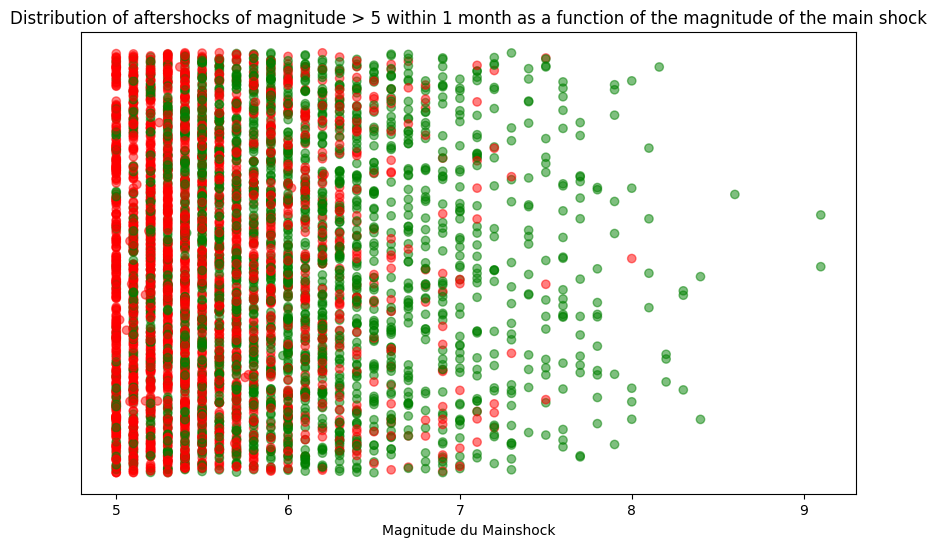

In [451]:
#We want to have a visual representation of the problem. We plot all the mainshocks according to their magnitude.
#green means the shock is followed by at least one big aftershock (mag >5)
plt.figure(figsize=(10, 6))
plt.scatter(decision_tree_data['MS_mag'], np.random.rand(len(decision_tree_data)), 
            c=decision_tree_data['boolean_aftershocks_mag_sup_M_in_1_month'].map({True: 'green', False: 'red'}), 
            marker='o', alpha=0.5)
plt.yticks([])  # Supprime les graduations sur l'axe des y
plt.xlabel('Magnitude du Mainshock')
plt.title('Distribution of aftershocks of magnitude > 5 within 1 month as a function of the magnitude of the main shock')
plt.show()

From this graph we can see that the larger the magnitude of the mainshock, the higher the probability that it will be followed by at least one large aftershock (of mag > 5).
For example, all mainshocks with a magnitude greater than 8 have at least one large aftershock. For mainshocks with magnitudes between 5 and 6, it is not so simple.

---

### Adding zone parameters on the shocks frame

In [452]:

decision_tree_data = pd.merge(decision_tree_data, region_data_stats,on=['MC_lab','SC_lab'],how='left').reset_index(drop=True)
decision_tree_data.head(3)

,MS_depth,MS_lat,MS_long,MS_mag,foreshock_numbers,aftershock_numbers,MC_lab,SC_lab,foreshock_max,boolean_aftershocks_mag_sup_M_in_1_month,...,shocks_small,shocks_moderate,shocks_large,yearly_variations_region,monthly_variations_region,weekly_variations_region,monthly_mean_region,yearly_mean_region,weekly_mean_region,std_distance_region
0,159.80,-7.3950,128.2600,5.9,2,32,0,0,4.6,True,...,2550,185,21,140.547875,14.850544,4.331878,24.389381,131.238095,5.914163,2.154015
1,112.00,-7.4400,128.2209,6.5,39,39,0,0,6.0,True,...,2550,185,21,140.547875,14.850544,4.331878,24.389381,131.238095,5.914163,2.154015
2,9.87,-7.0269,128.3791,6.4,54,171,0,0,5.0,True,...,2550,185,21,140.547875,14.850544,4.331878,24.389381,131.238095,5.914163,2.154015


---

## Decision tree classifier

In [453]:
#we define the X and Y of the decision tree (X will be reduced in the next cells)
Y_classifier = decision_tree_data[['boolean_aftershocks_mag_sup_M_in_1_month']]
X_classifier = decision_tree_data.drop(['aftershock_numbers','MC_lab','SC_lab'] , axis=1).copy()

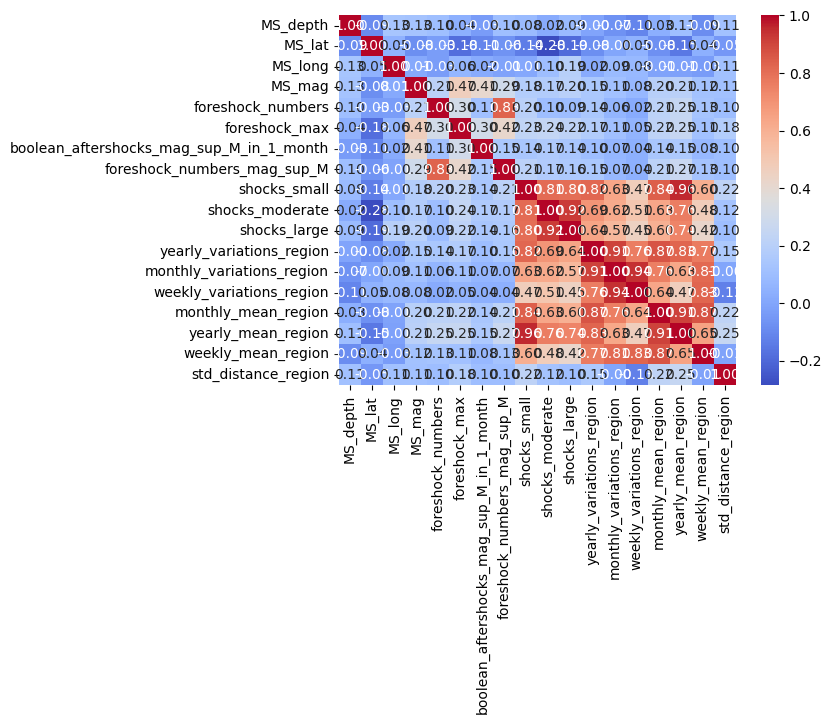

In [454]:
#let's see the correlation between our parameters
correlation_matrix = X_classifier.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Thanks to the correlation matrix, we see that the annual, monthly and weekly characteristics we calculated for the regions are redundant.
To avoid redundancy, we remove the parameters that are too highly correlated. We keep the monthly characteristics as the objective is to have a prediction within one month.

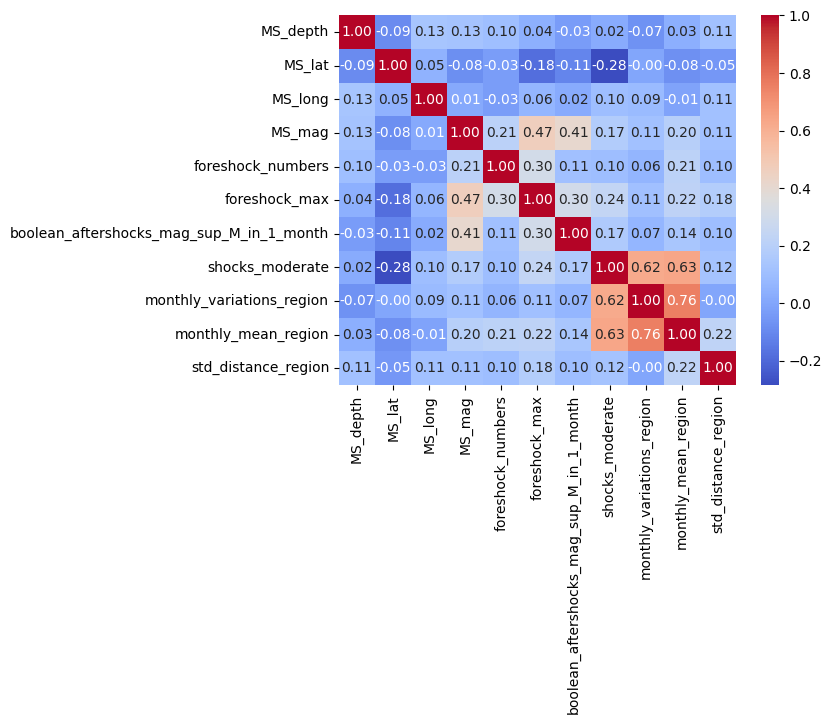

In [457]:
X_classifier=X_classifier.drop(['foreshock_numbers_mag_sup_M','shocks_large','shocks_small','yearly_mean_region','weekly_mean_region','weekly_variations_region','yearly_variations_region'],axis=1).copy()
correlation_matrix = X_classifier.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

We notice that some parameters are not correlated at all with the target_value (the boolean). The correlation between this target and the depth, longitude and latitude of the mainshock is zero (even negative). This is quite surprising!
We remove these features from the X inputs as they add no information to our prediction.
We have removed many of the features we created. However, some of the features we created seem quite relevant.

In [458]:
#we don't forget to remove the target from the X feature 
X_classifier=X_classifier.drop(['MS_lat','MS_long','MS_depth','boolean_aftershocks_mag_sup_M_in_1_month'],axis=1).copy()

### Feature standartization and splitting the data

In [459]:
#feature standardization
scaler = StandardScaler()
scaled_X_classifier = scaler.fit_transform(X_classifier)
#split the data in train and test set
X_classifier_train, X_classifier_test, Y_classifier_train, Y_classifier_test, indices_train, indices_test = train_test_split(scaled_X_classifier, Y_classifier, range(len(scaled_X_classifier)), test_size=0.30, random_state=40)


---

### Hyperparameter tuning


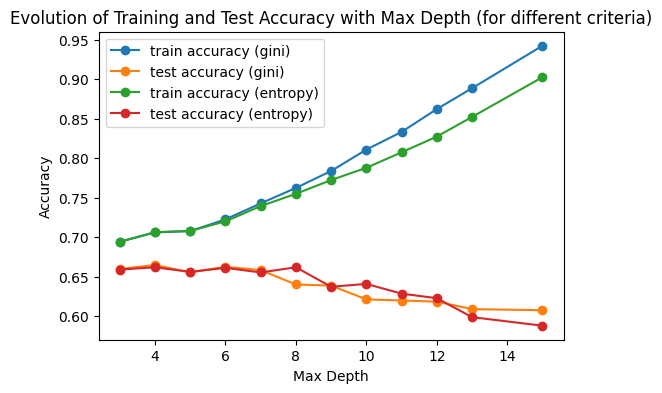

In [460]:
# we investigate and try different values for max_depth and criterion

def train_and_predict(depth, criterion):
    #trains a decision tree classifier and predict the outputs
    #input : the depth of the tree we want to try, and the criterion value
    #returns the predicted probabilities and metrics criteria
    tree_reg_classifier = DecisionTreeClassifier(max_depth=depth, criterion=criterion, random_state=42)
    tree_reg_classifier.fit(X_classifier_train, Y_classifier_train)
    
    # predictions on the training and test sets
    y_train_pred = tree_reg_classifier.predict(X_classifier_train)
    y_test_pred = tree_reg_classifier.predict(X_classifier_test)
    
    # predictions on the testing and test sets
    y_pred_proba_test = tree_reg_classifier.predict_proba(X_classifier_test)[:, 1]
    y_pred_proba_train = tree_reg_classifier.predict_proba(X_classifier_train)[:, 1]

    # calculate metrics for the training set
    train_accuracy = accuracy_score(Y_classifier_train, y_train_pred)
    train_f1 = f1_score(Y_classifier_train, y_train_pred)
    train_precision = precision_score(Y_classifier_train, y_train_pred)
    train_recall = recall_score(Y_classifier_train, y_train_pred)

    # calculate metrics for the testing set
    test_accuracy = accuracy_score(Y_classifier_test, y_test_pred)
    test_f1 = f1_score(Y_classifier_test, y_test_pred)
    test_precision = precision_score(Y_classifier_test, y_test_pred)
    test_recall = recall_score(Y_classifier_test, y_test_pred)

    #calculate auc
    auc_test = roc_auc_score(Y_classifier_test, y_pred_proba_test)
    auc_train = roc_auc_score(Y_classifier_train, y_pred_proba_train)

    results = {
        'depth': depth,
        'criterion': criterion,
        'train accuracy': train_accuracy,
        'test accuracy': test_accuracy,
        'train F1': train_f1,
        'test F1': test_f1,
        'AUC train': auc_train,
        'AUC test': auc_test,
        'train precision': train_precision,
        'train recall': train_recall,
        'test precision': test_precision,
        'test recall': test_recall
    }

    return results, y_pred_proba_test

max_depth = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
criterion_values = ['gini', 'entropy']
results_list = []

for depth in max_depth:
    for criterion_value in criterion_values:
        results, _ = train_and_predict(depth, criterion_value)
        results_list.append(results)

results_df = pd.DataFrame(results_list)

plt.figure(figsize=(6, 4))
for criterion_value in criterion_values:
    criterion_df = results_df[results_df['criterion'] == criterion_value]
    plt.plot(criterion_df['depth'], criterion_df['train accuracy'], label=f'train accuracy ({criterion_value})', marker='o')
    plt.plot(criterion_df['depth'], criterion_df['test accuracy'], label=f'test accuracy ({criterion_value})', marker='o')

# we plot the evolution of training and test accuracy with max_depth
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Evolution of Training and Test Accuracy with Max Depth (for different criteria)')
plt.legend()
plt.show()


In [461]:

# we want to plot the table of the metrics to compare the hyperparameters

results_df = results_df.drop(['train precision','train recall','test precision','test recall'], axis = 1).round(2)
print(tabulate(results_df, headers='keys', tablefmt='pretty'))


+----+-------+-----------+----------------+---------------+----------+---------+-----------+----------+
|    | depth | criterion | train accuracy | test accuracy | train F1 | test F1 | AUC train | AUC test |
+----+-------+-----------+----------------+---------------+----------+---------+-----------+----------+
| 0  |   3   |   gini    |      0.69      |     0.66      |   0.65   |  0.61   |   0.75    |   0.71   |
| 1  |   3   |  entropy  |      0.69      |     0.66      |   0.65   |  0.61   |   0.75    |   0.71   |
| 2  |   4   |   gini    |      0.71      |     0.66      |   0.72   |  0.68   |   0.77    |   0.72   |
| 3  |   4   |  entropy  |      0.71      |     0.66      |   0.72   |  0.68   |   0.77    |   0.72   |
| 4  |   5   |   gini    |      0.71      |     0.66      |   0.67   |  0.61   |   0.79    |   0.72   |
| 5  |   5   |  entropy  |      0.71      |     0.66      |   0.67   |  0.61   |   0.79    |   0.72   |
| 6  |   6   |   gini    |      0.72      |     0.66      |   0.

As the data is fairly balanced, we decided to optimise the accuracy to choose the best parameter. 
We want both the training and testing accuracy to be as high as possible. However, we have to make a compromise to avoid overfitting.
We set the accuracy to 8. In fact, after this value, the accuracy is better on the training set, but decreases a lot on the test set. We have chosen the parameter "gini" for the criterion, because the accuracy is slightly better for an accuracy of , but this parameter does not seem to have much impact (at least for small values of max_depth).

---
### Best tree


In [462]:
#This is the best decision tree so far
tree_reg_classifier = DecisionTreeClassifier(max_depth = 8 ,criterion="entropy", random_state=42)
tree_reg_classifier.fit(X_classifier_train, Y_classifier_train)
y_pred_proba = tree_reg_classifier.predict_proba(X_classifier_test)[:, 1]
y_pred_test = tree_reg_classifier.predict(X_classifier_test)

---

## Confusion matrix

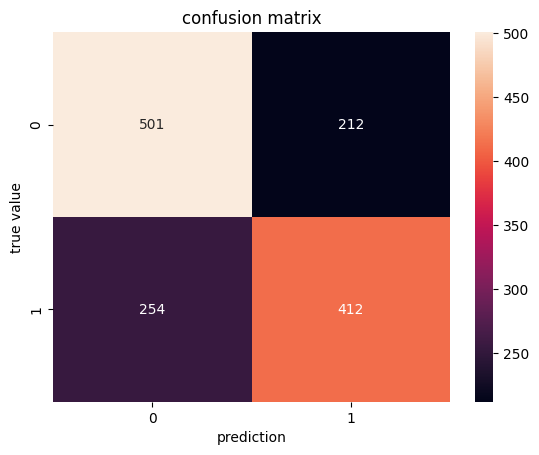

In [463]:

#Let's plot the confusion matrix to have a visual representation of true positives, false positives, ...
cm = confusion_matrix(Y_classifier_test,y_pred_test)
plt.figure()
sns.heatmap(cm,annot = True, fmt = "d")
plt.title("confusion matrix")
plt.xlabel("prediction")
plt.ylabel("true value")
plt.show()

We see that there are a lot of false negative. In our context, we prefer to have false positive than false negative. To solve this, we can lower the freshold of the decision tree. In fact, lower the freshold means classifying instances as positive even if the predicated probability is below 0.5. 

### Threshold values investigation to fit to our specific problem

In [464]:
#Let's change the threshold values
threshold_values = [0.3,0.35,0.4,0.45,0.5]

for threshold in threshold_values:
    y_pred_threshold = [1 if pred >= threshold else 0 for pred in y_pred_proba]
    cm = confusion_matrix(Y_classifier_test,y_pred_threshold)
    print(" Threshold : ", threshold)
    print("confusion matrix : ")
    print(cm)
    print("---------------")


 Threshold :  0.3
confusion matrix : 
[[294 419]
 [128 538]]
---------------
 Threshold :  0.35
confusion matrix : 
[[426 287]
 [190 476]]
---------------
 Threshold :  0.4
confusion matrix : 
[[426 287]
 [190 476]]
---------------
 Threshold :  0.45
confusion matrix : 
[[443 270]
 [202 464]]
---------------
 Threshold :  0.5
confusion matrix : 
[[492 221]
 [246 420]]
---------------


A threshold of 0.4 significantly reduces the number of false negatives without affecting the other values too much.

---

## Final tree

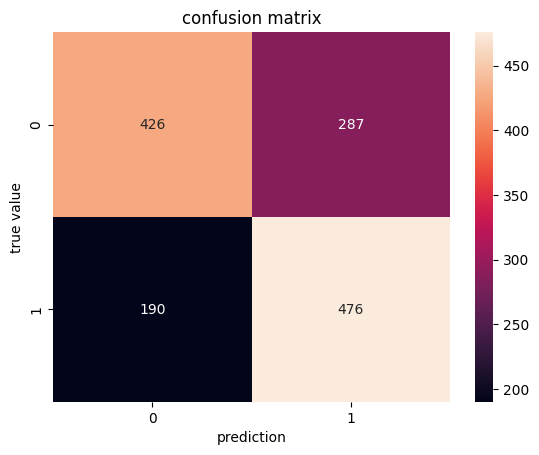

In [465]:
#That is our final tree
tree_reg_classifier = DecisionTreeClassifier(max_depth = 8 ,criterion="entropy", random_state=42)
tree_reg_classifier.fit(X_classifier_train, Y_classifier_train)

# Predictions
y_train_pred = tree_reg_classifier.predict(X_classifier_train)
y_test_pred = tree_reg_classifier.predict(X_classifier_test)

y_pred_proba_test = tree_reg_classifier.predict_proba(X_classifier_test)[:,1]
y_pred_proba_train = tree_reg_classifier.predict_proba(X_classifier_train)[:,1]

y_pred_threshold_test = [1 if pred >= 0.4 else 0 for pred in y_pred_proba_test]
y_pred_threshold_train = [1 if pred >= 0.4 else 0 for pred in y_pred_proba_train]

#Let's plot the confusion matrix
cm = confusion_matrix(Y_classifier_test,y_pred_threshold_test)
plt.figure()
sns.heatmap(cm,annot = True, fmt = "d")
plt.title("confusion matrix")
plt.xlabel("prediction")
plt.ylabel("true value")
plt.show()

In [466]:
# We calculate metrics for training set
train_accuracy = accuracy_score(Y_classifier_train, y_train_pred)
train_f1 = f1_score(Y_classifier_train, y_train_pred)
train_auc = roc_auc_score(Y_classifier_train, tree_reg_classifier.predict_proba(X_classifier_train)[:, 1])

# We calculate metrics for test set
test_accuracy = accuracy_score(Y_classifier_test, y_test_pred)
test_f1 = f1_score(Y_classifier_test, y_test_pred)
test_auc = roc_auc_score(Y_classifier_test, tree_reg_classifier.predict_proba(X_classifier_test)[:, 1])

# We display results in a table
table = [["Metric", "Training Set", "Test Set"],
         ["Accuracy", f"{train_accuracy:.4f}", f"{test_accuracy:.4f}"],
         ["F1 Score", f"{train_f1:.4f}", f"{test_f1:.4f}"],
         ["AUC", f"{train_auc:.4f}", f"{test_auc:.4f}"]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))



╒══════════╤════════════════╤════════════╕
│ Metric   │   Training Set │   Test Set │
╞══════════╪════════════════╪════════════╡
│ Accuracy │         0.7551 │     0.6621 │
├──────────┼────────────────┼────────────┤
│ F1 Score │         0.7392 │     0.6388 │
├──────────┼────────────────┼────────────┤
│ AUC      │         0.8427 │     0.6924 │
╘══════════╧════════════════╧════════════╛


We still have some false negatives, but this is the best we could do with the data we have. Now we have a bit too much of false negatives... We should not forget that the data we are using here is generated from our clustering. We managed to get good results (the evaluation metrics are not bad). However, the hypothesis made may not be realistic.